<br>

## Loading libraries

In [1]:
# core
import time
import pandas as pd
import numpy as np
import wandb
from tqdm import tqdm

# graphics
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix

# torch
import torch
from torch import optim
from torch.utils.data import DataLoader

# custom functions
from custom import *
from imblearn.over_sampling import RandomOverSampler

wandb.login()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

wandb: Currently logged in as: vinas (use `wandb login --relogin` to force relogin)


<br>
<br>
<br>

## Defining the model parameters and the training pipeline

In [ ]:
PARAMS = {
    'batch_size': 1024,
    'n_days': 7,
    'epochs': 500,
    'lr': 0.01,
    'cities': [],
    'features': [],
    'oversample': True,
    'scheduler': False
}

In [ ]:
def pipeline(PARAMS):

    with wandb.init(config=PARAMS, group=int(time.time())):
        PARAMS = wandb.config
        run_id = wandb.run.id
        
        # parsing and loading the data
        trainloader, testloader = parse_and_prep_data(PARAMS)

        # setting some more parameters
        r = trainloader.dataset.len / trainloader.dataset.y.sum() - 1
        r -= 1.5
        r = 1
        wandb.config.update({'r': r, 'n_features': trainloader.dataset.x.shape[2]})
        PARAMS = wandb.config

        # defining the model and other functions
        model, loss, optimiser, scheduler = define_model(PARAMS)

        # starting the training loop
        train(trainloader, testloader, model, loss, optimiser, scheduler)
    
    return model, run_id

<br>
<br>
<br>

## Parsing and prepping the data

In [2]:
def parse_and_prep_data(PARAMS):

    # Reading in the data
    X_train, y_train = read_and_parse('train', cities=PARAMS['cities'], columns=PARAMS['features'])
    X_test, y_test = read_and_parse('test', cities=PARAMS['cities'], columns=PARAMS['features'])

    # Transforming data into input/output pairs
    X_train, y_train = transform_to_TS(X_train, y_train, n=PARAMS['n_days'])
    X_test, y_test = transform_to_TS(X_test, y_test, n=PARAMS['n_days'])

    # Oversampling minority class
    if PARAMS['oversample']:
        oversample = RandomOverSampler(sampling_strategy='minority')
        _ = oversample.fit_resample(X_train[:,:,0], y_train)
        X_train = X_train[oversample.sample_indices_]
        y_train = y_train[oversample.sample_indices_]

    # Creating torch class datasets
    train_dataset = timeseries(X_train, y_train)
    test_dataset = timeseries(X_test, y_test)

    # # Setting up dataloaders
    trainloader = DataLoader(train_dataset, shuffle=True, batch_size=PARAMS['batch_size'])
    testloader = DataLoader(test_dataset, shuffle=True, batch_size=PARAMS['batch_size'])
    
    return trainloader, testloader

<br>
<br>
<br>

## Setting up the model

In [ ]:
def define_model(PARAMS):

    model = LSTM(PARAMS['n_features'])
    loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(PARAMS['r'])) # pos_weight > 1 will increase the recall while pos_weight < 1 will increase the precision.
    optimiser = optim.Adam(model.parameters(), lr=PARAMS['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.1, patience=10, verbose=True)
    
    return model, loss, optimiser, scheduler

<br>
<br>
<br>

## Defining training loop

In [ ]:
def train(trainloader, testloader, model, loss, optimiser, scheduler):

    wandb.watch(model, loss, log='all', log_freq=10)
    pbar = tqdm(range(PARAMS['epochs']))
    
    for epoch in pbar:

        model.train()
        loss_tr = 0
        corr_tr = 0
        for data in trainloader:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimiser.zero_grad()

            # forward + loss + backward + optimise (update weights)
            outputs = model(inputs)
            L = loss(outputs, labels)
            L.backward()
            optimiser.step()

            # keep track of the loss and accuracy this epoch
            loss_tr += L.item()
            preds = torch.sigmoid(outputs).round()
            corr_tr += (preds==labels).sum().item()

        if PARAMS['scheduler']:
            scheduler.step(loss_tr)
            wandb.log({'lr': optimiser.param_groups[0]['lr']}, step=epoch)

        acc_tr = corr_tr / trainloader.dataset.x.shape[0]
        loss_tr = loss_tr / (trainloader.dataset.x.shape[0] / testloader.dataset.x.shape[0])

        # Rescaling to fit test data
        k = len(trainloader) / (trainloader.dataset.len / testloader.dataset.len)
        loss_tr /= k

        wandb.log({'loss_tr': loss_tr, 'acc_tr': acc_tr}, step=epoch)


        # Model evaluation
        model.eval()

        # test accuracy
        y_hat_test = get_predictions(testloader.dataset.x, model=model)
        acc_tt = accuracy_score(testloader.dataset.y, y_hat_test)

        # test loss
        outputs = model(testloader.dataset.x)
        loss_tt = loss(outputs, testloader.dataset.y).item()

        wandb.log({'loss_tt': loss_tt, 'acc_tt': acc_tt,
                   'f1': f1_score(testloader.dataset.y, y_hat_test),
                   'f1_avg': np.mean([f1_score(testloader.dataset.y, y_hat_test), f1_score(1-testloader.dataset.y, 1-y_hat_test)])}, step=epoch)


        pbar.set_postfix({'test_accuracy': acc_tt,  'test_loss': loss_tt, 'train_accuracy': acc_tr, 'train_loss': loss_tr})
        
    clr = class_report(testloader.dataset.y, y_hat_test, reset_index=True)
    wandb.log({'classification_report': wandb.Table(dataframe=clr)})
    wandb.log({'confusion_matrix':
           wandb.plot.confusion_matrix(y_true=testloader.dataset.y.squeeze().numpy(),
                                       preds=y_hat_test.squeeze())})
    
    torch.onnx.export(model, testloader.__iter__().__next__()[0][0].unsqueeze(0), './model.onnx')
    torch.save(model.state_dict(), './model.weights')
    wandb.save('./model.onnx')
    wandb.save('./model.weights')

<br>
<br>
<br>

## Running the pipe

In [ ]:
model, run_id = pipeline(PARAMS)

<br>
<br>
<br>

## Loading the trained model and training history

In [3]:
run_id = 'enhpfyxm'

In [4]:
run = wandb.Api().run(f'/RainAustralia/{run_id}')
run.file('model.weights').download(replace=True)
model = LSTM(run.config['n_features'])
model.load_state_dict(torch.load('./model.weights'))
history = run.history()
_, testloader = parse_and_prep_data(run.config)

<br>
<br>
<br>

## Preliminary visualisation

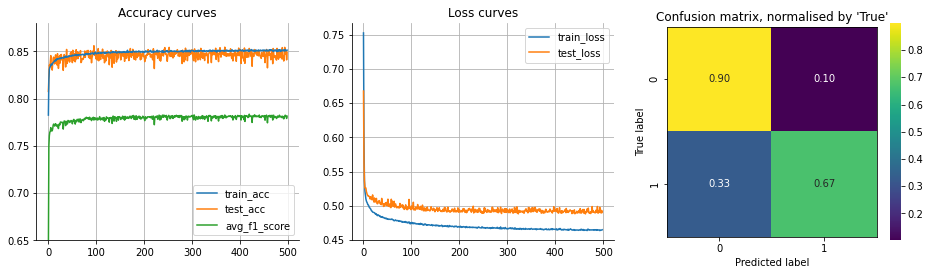

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

def reorderLegend(order, ax):
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[i] for i in order], [labels[i] for i in order])
    
def left(ax=ax[0]):
    ax.plot(history['acc_tt'], label='test_acc', color='#FF7F0E')
    ax.plot(history['acc_tr'], label='train_acc', color='#1F77B4')
    ax.plot(history['f1_avg'], label='avg_f1_score', color='#2CA02C')
    reorderLegend([1, 0, 2], ax)
    ax.grid()
    ax.set_ylim([0.65, 0.88])
    ax.set_title('Accuracy curves')
    sns.despine(ax=ax)
    
    
def mid(ax=ax[1]):
    ax.plot(history['loss_tr'], label='train_loss')
    ax.plot(history['loss_tt'], label='test_loss')
    ax.legend()
    ax.grid()
    ax.set_title('Loss curves')
    sns.despine(ax=ax)
    
def right(ax=ax[2]):
    plot_conf_matrix(testloader.dataset.y, y_hat_test, normalise='true', ax=ax)
    ax.set_title('Confusion matrix, normalised by \'True\'')
    

y_hat_test = get_predictions(testloader.dataset.x, model=model)

left()
mid()
right()

# plt.savefig('./Plots/<>.png', bbox_inches='tight', pad_inches=0.1)

In [6]:
clr = class_report(testloader.dataset.y, y_hat_test)
clr

,precision,recall,f1-score,support
0.0,0.91,0.90,0.90,31774
1.0,0.65,0.67,0.66,8925
accuracy,0.85,0.85,0.85,40699
macro avg,0.78,0.78,0.78,40699
weighted avg,0.85,0.85,0.85,40699
